In [ ]:
# LEAFToolbox-SL2P
#
# Applies the LEAF-ToolBox-SL2P to process input images on Googe Earth Engine
# AND exports to google drive.
# 
# Note: This is an exact copy of LEAF-ToolBox-SL2P for image by image products
# as implemented on February 10, 2021 16:00 EST
# https://code.earthengine.google.com/fd6bddb89803bd8ea45fdcad051f75cc
#
# You will need a Google Earth Engine Account linked to a Google Account with sufficient
# disk space for the output.
#
# Refer to https://github.com/rfernand387/LEAF-Toolbox/tree/master/Source-Python 
# for configuration of anaconda environment.

In [ ]:
# The purpose of this notebook is to compare the SL2P algorithm with two versions of SL2P10
    # (a) SL2P10_20m – resampling 10 m bands to 20 m, then applying the algorithm
    # (b) SL2P10_10m – using 10 m bands as input and resampling the values afterwards

### IMPORTANT ### : run block [54] to select the 10 m data set BEFORE running block [55] and/or [56]

# Block [53] contains the original SL2P, and blocks [55] and [56] perform SL2P10_20m and SL2P10_10m, respectively
# Histograms comparing the results of both SL2P10 versions can be found in block [59]

# See LEAFToolbox-SL2P.ipynb to run original SL2P

In [2]:
import ee
import geetools
import folium ; from folium import plugins
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import sklearn ; from sklearn import linear_model

In [4]:
ee.Authenticate()

Enter verification code:  4/1AX4XfWiysSVACqpLUqr2JDQ0zLKkjYsgITMeQ2zchwEjLs5iGwqd7Umka8Y



Successfully saved authorization token.


In [5]:
# Authorizes the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [259]:
# input parameters (to modify)

# product name, one of('Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF')
outputName = "LAI"

# output parameters, outputScale and outputOffset not applied to "Surface_Reflectance"
# create a dictionary for output parameters based on outputName
outputParams = {
    'Surface_Reflectance': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 1
    },
    'Albedo': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 1
    },
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 1
    },
    # min: 0, max: 8.0
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 10,
        'outputMax': 8
    },
    'CCC': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 6
    },
    # min: 0, max: 0.55
    'CWC': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 0.55
    },
    'DASF': {
        'outputScale': 1000,
        'outputOffset': 0,
        'multiplier': 1,
        'outputMax': 1
    }
}
    
outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']
multiplier = outputParams[outputName]['multiplier']

# date range for inputs
startDate = ee.Date('2020-08-01')
endDate = ee.Date('2020-08-5')

# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
# will modify for each of the three test regions
mapBounds =  ee.Geometry.Polygon( \
        [[[-75, 45], \
          [-75, 46], \
          [-74, 46], \
          [-74, 45]]])

# other filters - for now only cloud cover
maxCloudcover = 10

# export parameters
exportFolder = "export_"+outputName
exportScale = 20
exportDatatype = "int"

In [7]:
# verify status of tasks
def check_ee_tasks(ee_tasks: list = []):
    for task in ee_tasks:
        taskStatus = ee.data.getTaskStatus(task.id)[0]
        print(taskStatus["description"] + ": " + taskStatus["state"])

In [8]:
# wait loop for Earth Engine tasks to complete. Polls for the task status the specificed number of seconds until it is no longer active
def task_wait_loop(ee_task, wait_interval):
    print(ee.data.getTaskStatus(ee_task.id)[0]["description"] + ":", end = " ")
    prev_task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
    print(prev_task_status, end = " ")
    while ee_task.active():
        task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
        if(task_status != prev_task_status):
            print(task_status, end = " ")
        prev_task_status = task_status
        time.sleep(wait_interval)
    print(ee.data.getTaskStatus(ee_task.id)[0]["state"])

In [9]:
# create a folium map object
def displayImage(image,minVal,maxVal) :
    my_map = folium.Map(location = [45.5, -75], zoom_start = 8, height = 500)
    vis_params = {
      'min': minVal,
      'max': maxVal}
    my_map.add_ee_layer(image, vis_params, 'Image')
    
    # add a layer control panel to the map.
    my_map.add_child(folium.LayerControl())

    # add fullscreen button
    plugins.Fullscreen().add_to(my_map)

    # display the map.
    display(my_map)

In [10]:
# define a method for displaying Earth Engine image tiles on a folium map
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

In [11]:
default_asset_location = "users/hemitshah"

def export_collection_to_gee(collection, num_images: int = 0, image_names: list = [], asset_folder: str = default_asset_location, scale: float = 20, max_pixels: int = 1e8, data_type: str = "float"):
    collection = ee.ImageCollection(collection)
    image_list = collection.toList(num_images)
    task_list = []
    
    for i in range(num_images):
        image = ee.Image(image_list.get(i))
        name = image_names[i]
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        export_task = ee.batch.Export.image.toAsset(image = typed_images[data_type],
                                                      description = name,
                                                      assetId = asset_folder+"/"+name,
                                                      region = image.geometry(),
                                                      scale = scale,
                                                      maxPixels = max_pixels)
        export_task.start()
        task_list.append(export_task)
    
    return task_list

In [12]:
def export_collection_to_drive(collection, num_images: int = 0, image_names: list = [], gdrive_folder: str = "", scale: float = 20, max_pixels: int = 1e8, data_type: str = "float"):
    collection = ee.ImageCollection(collection)
    image_list = collection.toList(num_images)
    task_list = []

    for i in range(num_images):
        image = ee.Image(image_list.get(i))
        name = image_names[i]
        print(name)
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        export_task = ee.batch.Export.image.toDrive(image = typed_images[data_type],
                                                    description = name,
                                                    folder = gdrive_folder,
                                                    fileNamePrefix = name,
                                                    region = image.geometry(),
                                                    scale = scale,
                                                    maxPixels = max_pixels)
        export_task.start()
        task_list.append(export_task)
    
    return task_list

In [13]:
def s2_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1')

In [14]:
# same function as above using 10 m bands
def s2_10m_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/kateharvey/s2_sl2p_weiss_or_prosail_10m_NNT1_Single_0_1')

In [15]:
def s2_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1_error')

In [16]:
# same function as above using 10 m bands
def s2_10m_createFeatureCollection_errors():
    return ee.FeatureCollection('users/kateharvey/s2_sl2p_weiss_or_prosail_10m_NNT1_Single_0_1_errors')

In [17]:
def s2_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/weiss_or_prosail3_NNT3_Single_0_1_DOMAIN')

In [18]:
# same function as above using 10 m bands
def s2_10m_createFeatureCollection_domains():
    return ee.FeatureCollection('users/kateharvey/s2_sl2p_weiss_or_prosail_10m_domain')

In [19]:
def s2_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/weiss_or_prosail3_NNT3_Single_0_1_RANGE')

In [20]:
def s2_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Parameter_file_sl2p')

In [21]:
def s2_createImageCollection_partition():
    return ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles').map(lambda image: image.select("b1").rename("partition")).merge(ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global").map( lambda image: image.select("discrete_classification").remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")))

In [22]:
def s2_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Legend_sl2p')

In [23]:
def l8_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_OUTPUT')

In [24]:
def l8_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_ERRORS')

In [25]:
def l8_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_DOMAIN')

In [26]:
def l8_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_RANGE')

In [27]:
def l8_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Parameter_file_sl2p')

In [28]:
def l8_createImageCollection_partition():
    return ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles').map(lambda image: image.select("b1").rename("partition")).merge(ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global").map( lambda image: image.select("discrete_classification").remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")))

In [29]:
def l8_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Legend_sl2p')

In [30]:
# add a 'date' band: number of days since epoch
def addDate(image):
    return image.addBands(ee.Image.constant(ee.Date(image.date()).millis().divide(86400000)).rename('date').toUint16())

In [31]:
# computes a delta time property for an image
def deltaTime(midDate,image):
    return ee.Image(image.set("deltaTime",ee.Number(image.date().millis()).subtract(ee.Number(midDate)).abs()))

In [32]:
# mask pixels that are not clear sky in a S2 MSI image
def s2MaskClear(image):
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0))
    return image.updateMask(mask)

In [33]:
# add s2 geometry bands scaled by 10000
def addS2Geometry(colOptions,image) :
    return (image.addBands(ee.Image.constant(0).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosVZA']))
              .addBands(image.metadata(colOptions["sza"]).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosSZA']))
              .addBands(image.metadata(colOptions["saa"]).subtract(image.metadata(colOptions["saa"])).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosRAA'])))

In [34]:
# Sentinel 2 land mask
def s2MaskLand(image) :
    return image.updateMask((image.select('SCL').eq(4)).Or(image.select('SCL').eq(5)))

In [35]:
# returns image with selected bands scaled
def scaleBands(bandList,scaleList,image) :
    bandList = ee.List(bandList)
    scaleList = ee.List(scaleList)
    return image.addBands(srcImg = image.select(bandList).multiply(ee.Image.constant(scaleList)).rename(bandList),overwrite = True)

In [36]:
# determine if inputs fall in domain of algorithm
# need to be updated to allow for the domain to vary with partition
def invalidInput(sl2pDomain,bandList,image) :
    sl2pDomain = ee.FeatureCollection(sl2pDomain).aggregate_array("DomainCode").sort()
    bandList = ee.List(bandList).slice(3)
    image = ee.Image(image)

    # code image bands into a single band and compare to valid codes to make QC band
    image = image.addBands(image.select(bandList).multiply(ee.Image.constant(ee.Number(10))).ceil().mod(ee.Number(10)).uint8()
                              .multiply(ee.Image.constant(ee.List.sequence(0,bandList.length().subtract(1)).map(lambda value: ee.Number(10).pow(ee.Number(value)))))
                              .reduce("sum").remap(sl2pDomain, ee.List.repeat(0, sl2pDomain.length()),1).rename("QC"))
    return image

In [37]:
# reduces all bands of input image to 20 m
def reduceTo20m(input_image):
    image = input_image

    # set a default projection to 20 m resolution using B11
    defaultCrs = 'EPSG:32618'
        # image.select(defaultBand).projection().crs()
    defaultScale = 20
        # image.select(defaultBand).projection().nominalScale()

    # load a copy of the image and reduce resolution using the above
    resampled_image = image.setDefaultProjection(crs=defaultCrs, scale=defaultScale)
    resampled_image = resampled_image.reduceResolution(reducer=ee.Reducer.mean(), bestEffort=True, maxPixels=ee.Number(2))
    
    return resampled_image

In [38]:
# returns image with single band named network id corresponding given 
def makeIndexLayer(image,legend,Network_Ind) :
    image = ee.Image(image)                          # partition image
    legend = ee.FeatureCollection(legend)            # legend to convert partition numbers to networks
    Network_Ind = ee.FeatureCollection(Network_Ind)  # legend to convert networks to networkIDs
    
    # get lists of valid partitions
    legend_list = legend.toList(legend.size())
    landcover = legend_list.map(lambda feature: ee.Feature(feature).getNumber('Value'))

    # get corresponding networkIDs
    networkIDs = legend_list.map(lambda feature: ee.Feature(feature).get('SL2P Network')) \
                                    .map(lambda propertyValue: ee.Feature(ee.FeatureCollection(Network_Ind).first()) \
                                    .toDictionary().getNumber(propertyValue))
    
    return image.remap(landcover, networkIDs, 0).rename('networkID')

In [39]:
# read coefficients of a network from csv EE asset
def getCoefs(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [40]:
# parse one row of CSV file for a network into a global variable
# we assume a two hidden layer network with tansig functions but allow for variable nodes per layer
def makeNets(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = {};
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net["inpSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["inpOffset"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outBias"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    return(ee.Dictionary(net))

In [41]:
# parse CSV file with list of networks for a selected variable  
# this will parse one network for each landclass partition
def makeNetVars(asset, numNets, variableNum) :
    
    asset= ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum= ee.Number(variableNum)  

    # get selected network 
    list_features = asset.flatten()
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))

In [42]:
# returns dictionary with image masked so the networkID band equals the netIndex and the corresponding network
def selectNet(image,netList,inputNames,netIndex) :
    
    image = ee.Image(image)
    netList = ee.List(netList)
    inputNames = ee.List(inputNames)
    netIndex = ee.Number(netIndex).int()
    
    return ee.Dictionary()  \
            .set("Image", ee.Image(image.updateMask(image.select('networkID').eq(netIndex)).select(inputNames))) \
            .set("Network", ee.List(netList.get(netIndex))) 

In [43]:
# applies two layer neural network within input and output scaling
def applyNet(outputName,netDict) :
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    
    # input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()).arrayProject([0]) \
                        .arrayFlatten([inp.bandNames()])) \
                        .add(ee.Image(net.toArray(ee.List(['inpOffset']),0).transpose()) \
                        .arrayProject([0]).arrayFlatten([inp.bandNames()]))
    
    # hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0).reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
              .matrixMultiply(l1inp2D.toArray().toArray(1)) \
              .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
              .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])) \
                    .reduce('sum') \
                    .add(ee.Image(net.toArray(ee.List(['h2bi']),0))) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2bi']])
    
    # output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))).divide(ee.Image(ee.Number(net.get('outSlope')))) 
    
    # return network output
    return (outputBand.rename(outputName))

In [44]:
# returns image with single band named networkid corresponding given 
# input partition image remapped to networkIDs
# applies a set of shallow networks to an image based on a provided partition image band
def wrapperNNets(network, partition, netOptions, colOptions, suffixName, imageInput) :

    # typecast function parameters
    network = ee.List(network)
    partition = ee.Image(partition)
    netOptions = netOptions
    colOptions = colOptions
    suffixName = suffixName
    imageInput = ee.Image(imageInput)

    # parse partition  used to identify network to use
    partition = partition.clip(imageInput.geometry()).select(['partition'])

    # determine networks based on collection
    netList = ee.List(network.get(ee.Number(netOptions.get("variable")).subtract(1))); 
    
    # parse land cover into network index and add to input image
    imageInput = imageInput.addBands(makeIndexLayer(partition,colOptions["legend"],colOptions["Network_Ind"]))

    # define list of input names
    return ee.ImageCollection(ee.List.sequence(0, netList.size().subtract(1)) \
                                                    .map(lambda netIndex: selectNet(imageInput,netList,netOptions["inputBands"],netIndex)) \
                                                    .map(lambda netDict: applyNet(suffixName+outputName,netDict))) \
                                                    .max().addBands(partition).addBands(imageInput.select('networkID'))

In [45]:
# returns dictionary with image masked so the networkID band equals the netIndex and the corresponding network
def selectNet2(image,netList,inputNames,netIndex) :
    image = ee.Image(image)
    netList = ee.List(netList)
    inputNames = ee.List(inputNames)
    netIndex = ee.Number(netIndex).int()
    result = ee.Dictionary() \
            .set("Image", ee.Image(image.updateMask(image.select('networkID').eq(netIndex)).select(inputNames))) \
            .set("Network", ee.List(netList.get(netIndex)))
    return result

In [46]:
# applies two layer neural network within input and output scaling
def applyNet2(outputName,netDict) :
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    
    # input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()).arrayProject([0]) \
                           .arrayFlatten([inp.bandNames()])).add(ee.Image(net.toArray(ee.List(['inpOffset']),0) \
                           .transpose()).arrayProject([0]).arrayFlatten([inp.bandNames()]))

    # hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0) \
                    .reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
                    .matrixMultiply(l1inp2D.toArray().toArray(1)) \
                    .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
                    .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()).arrayProject([0]) \
                            .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])).reduce('sum') \
                            .add(ee.Image(net.toArray(ee.List(['h2bi']),0))).arrayProject([0]).arrayFlatten([['h2bi']])
    
    # output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))).divide(ee.Image(ee.Number(net.get('outSlope')))) 

    # return network output
    return (outputBand.rename(outputName))

In [47]:
# read coefficients of a network from csv EE asset
def getCoefs2(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [48]:
# parse one row of CSV file for a network into a global variable
# We assume a two hidden layer network with tansig functions but allow for variable nodes per layer
def makeNets2(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = ee.Dictionary();
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpOffset", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outBias", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    return(net)


In [49]:
# parse CSV file with list of networks for a selected variable  
# this will parse one network for each landclass partition
def makeNetVars2(asset, numNets, variableNum) :
    
    asset = ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum = ee.Number(variableNum)
    
    # get selected network 
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    # make only first net
    netList = makeNets2(filtered_features,1)
    return netList
    # return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))

In [50]:
# returns image with single band named network id corresponding given 
def makeIndexLayer2(image,legend,Network_Ind) :
    
    image = ee.Image(image)                        # partition image
    legend = ee.FeatureCollection(legend)          # legend to convert partition numbers to networks
    Network_Ind = ee.FeatureCollection(Network_Ind) # legend to convert networks to networkIDs
    
    # get lists of valid partitions
    legend_list = legend.toList(legend.size())
    landcover = legend_list.map(lambda feature: ee.Feature(feature).getNumber('Value'))

    # get corresponding networkIDs
    networkIDs = legend_list.map(lambda feature: ee.Feature(feature).get('SL2P Network')) \
                              .map(lambda propertyValue:  ee.Feature(ee.FeatureCollection(Network_Ind).first()).toDictionary().getNumber(propertyValue))
    return image.remap(landcover, networkIDs, 0).rename('networkID')

In [51]:
# returns image with single band named networkid corresponding given 
# input partition image remapped to networkIDs
# applies a set of shallow networks to an image based on a provided partition image band
def wrapperNNets2(network, partition, netOptions, colOptions, layerName, imageInput) :

    # typecast function parameters
    network = ee.List(network)
    partition = ee.Image(partition)
    netOptions = ee.Dictionary(netOptions)
    colOptions = ee.Dictionary(colOptions)
    layerName = ee.String(layerName)
    imageInput = ee.Image(imageInput)

    # parse partition  used to identify network to use
    partition = partition.clip(imageInput.geometry()).select(['partition'])

    # determine networks based on collection
    netList = ee.List(network.get(ee.Number(netOptions.get("variable")).subtract(1))) 
    
    # parse land cover into network index and add to input image
    imageInput = imageInput.addBands(makeIndexLayer2(partition,colOptions.get("legend"),colOptions.get("Network_Ind")))


    # define list of input names
    netIndex = 0;
    netDict = ee.Dictionary(selectNet2(imageInput,netList,netOptions.get("inputBands"),netIndex));
    estimate = ee.Image(applyNet2(layerName,netDict))

    return estimate.addBands(partition).addBands(imageInput.select('networkID'))

In [260]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'LANDSAT/LC08/C01/T1_SR',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(l8_createImageCollection_partition()),
      "legend": ee.FeatureCollection(l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'Surface_Reflectance': {
        "COPERNICUS/S2_SR": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B4', 'B5', 'B6', 'B7', 'B8A', 'B9', 'B11', 'B12']
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp": ['B2', 'B3', 'B4', 'B8']
        }
    },
    'Albedo': {
        "COPERNICUS/S2_SR": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'CCC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
        }
    },
    'CWC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
        }
    },
    'DASF': {
        "COPERNICUS/S2_SR": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

In [265]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [266]:
# make products and export
# SL2P original

# filter collection and add ancillary bands
input_collection = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: s2MaskClear(image)) \
                     .map(lambda image: addS2Geometry(colOptions, image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    input_collection = input_collection.map(lambda image: s2MaskLand(image)) \
                                       .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                       .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image))
    
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite = True))
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    # export_collection = input_collection.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'date', 'QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    export_collection = input_collection.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'date', 'QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,multiplier*outputScale+outputOffset)

5


In [270]:
print(input_collection.first().getInfo()["bands"][0])

{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [163, 285], 'origin': [1667, 0], 'crs': 'EPSG:32618', 'crs_transform': [60, 0, 399960, 0, -60, 5000040]}


In [216]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [224]:
# ==========
# SL2P10_20m
# ==========
# performs same procedure as above block using SL2P10 network
# reduces image resolution before applying algorithm
    
# filter collection and add ancillary bands
input_collection_20m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: s2MaskClear(image)) \
                     .map(lambda image: addS2Geometry(colOptions, image)) \
                     .map(lambda image: reduceTo20m(image))
print(input_collection_20m.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection_20m = input_collection_20m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

    # pre process input imagery and flag invalid inputs
    input_collection_20m = input_collection_20m.map(lambda image: s2MaskLand(image)) \
                                               .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_20m = input_collection_20m.map(lambda image: wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image))
    uncertaintySL2P_20m = input_collection_20m.map(lambda image: wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image))

    # scale and offset mapped parameter bands
    estimateSL2P_20m = estimateSL2P_20m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                               .multiply(ee.Image.constant(outputScale)) \
                                                               .add(ee.Image.constant(outputOffset)), overwrite = True))
    uncertaintySL2P_20m = uncertaintySL2P_20m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                     .multiply(ee.Image.constant(outputScale)) \
                                                                     .add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    export_collection_20m = input_collection_20m.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'date', 'QC']).combine(estimateSL2P_20m).combine(uncertaintySL2P_20m)

image_output_names_20m = ([name+"_"+outputName+"_20m" for name in export_collection_20m.toList(export_collection_20m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
displayImage(export_collection_20m.mosaic().select('estimate'+outputName),0+outputOffset,multiplier*outputScale+outputOffset)

5


In [225]:
# ==========
# SL2P10_10m
# ==========
# performs same procedure as above block using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                     .filterBounds(mapBounds) \
                     .filterDate(startDate, endDate) \
                     .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                     .limit(5000) \
                     .map(lambda image: addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: s2MaskClear(image)) \
                     .map(lambda image: addS2Geometry(colOptions, image))
print(input_collection_10m.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection_10m = input_collection_10m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
    # pre process input imagery and flag invalid inputs
    input_collection_10m = input_collection_10m.map(lambda image: s2MaskLand(image)) \
                                       .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                       .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_10m = input_collection_10m.map(lambda image: wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image))
    uncertaintySL2P_10m = input_collection_10m.map(lambda image: wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image))
    
    # scale and offset mapped parameter bands
    estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                                 .multiply(ee.Image.constant(outputScale)) \
                                                                 .add(ee.Image.constant(outputOffset)), overwrite = True));
    uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                       .multiply(ee.Image.constant(outputScale)) \
                                                                       .add(ee.Image.constant(outputOffset)),overwrite = True));
    
    
    # produce final export collection
    export_collection_10m = input_collection.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'date', 'QC']).combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,multiplier*outputScale+outputOffset)

5


In [219]:
# combine all SL2P, SL2P10_10m, SL2P10_20m bands into a single image to sample corresponding pixel values

export_20m = export_collection_20m.first()
export_10m = export_collection_10m.first()

export_20m = export_20m.select('estimate'+outputName).rename('estimate'+outputName+'_20m')
export_10m = export_10m.select('estimate'+outputName).rename('estimate'+outputName+'_10m')

# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m).addBands(export_10m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName, 'estimate'+outputName+'_20m', 'estimate'+outputName+'_10m').sample(numPixels=5000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=10).getInfo()

list_length = len(samples['features'])
estimate_list = []

# populate an array with the estimate for SL2P, SL2P10_10m, SL2P10_20m
for i in range(list_length):
    temp_list = []
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_20m'])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_10m'])
    estimate_list.append(temp_list)

estimate_array = pd.DataFrame(estimate_list).rename(columns={0:'estimate'+outputName, 1:'estimate'+outputName+'_20m', 2:'estimate'+outputName+'_10m'})
estimate_array.head(10)

,estimatefAPAR,estimatefAPAR_20m,estimatefAPAR_10m
0,754.535558,860.529775,877.250868
1,469.651662,527.453464,539.729205
2,315.734525,296.489756,297.284650
3,730.683145,843.910942,857.298419
4,735.900953,893.605717,864.921681
5,751.307460,851.072457,847.522735
6,676.517686,814.469679,815.958722
7,683.784753,789.037950,791.713011
8,709.941429,825.280794,809.922137
9,353.343894,390.735065,436.056452


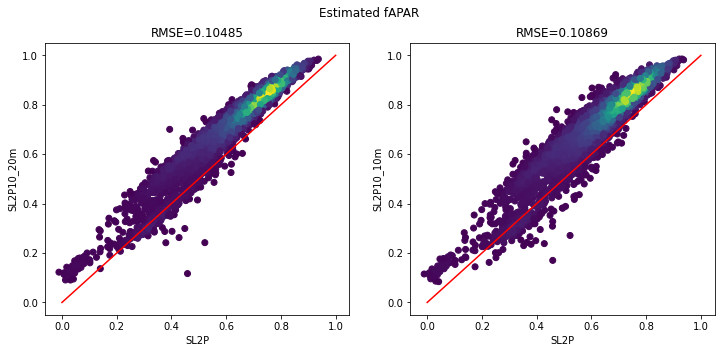

In [220]:
# plot density histogram of SL2P estimate vs (a) SL2P10_20m and (b) SL2P10_10m

sl2p = estimate_array['estimate'+outputName]/outputScale
sl2p10_10m = estimate_array['estimate'+outputName+'_10m']/outputScale
sl2p10_20m = estimate_array['estimate'+outputName+'_20m']/outputScale

# scipy.stats.gaussian_kde
xy_10m = np.vstack([sl2p, sl2p10_10m])
xy_20m = np.vstack([sl2p, sl2p10_20m])

density_10m = scipy.stats.gaussian_kde(xy_10m)(xy_10m)
density_20m = scipy.stats.gaussian_kde(xy_20m)(xy_20m)

rmse_10m = sklearn.metrics.mean_squared_error(sl2p, sl2p10_10m, squared=False)
rmse_20m = sklearn.metrics.mean_squared_error(sl2p, sl2p10_20m, squared=False)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
x = np.linspace(0,outputMax)
fig.suptitle('{}'.format('Estimated '+outputName))

# SL2P vs. SL2P10_20m
ax[0].scatter(sl2p, sl2p10_20m, c=density_20m)
ax[0].set_xlabel('SL2P')
ax[0].set_ylabel('SL2P10_20m')
ax[0].plot(x, x, c='r')
ax[0].title.set_text(f'RMSE={rmse_20m:.5f}')

# SL2P vs. SL2P10_10m
ax[1].scatter(sl2p, sl2p10_10m, c=density_10m)
ax[1].set_xlabel('SL2P')
ax[1].set_ylabel('SL2P10_10m')
ax[1].plot(x, x, c='r')
ax[1].title.set_text(f'RMSE={rmse_10m:.5f}')

In [222]:
# export above plot
export_fig = fig.savefig('Estimated_'+outputName+'.jpeg', bbox_inches = 'tight')

In [226]:
# export tasks to google drive
export_tasks = export_collection_to_drive(collection = export_collection, 
                                          num_images = export_collection.size().getInfo(), 
                                          image_names = image_output_names, 
                                          gdrive_folder = exportFolder, 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

export_tasks_20m = export_collection_to_drive(collection = export_collection_20m, 
                                          num_images = export_collection_20m.size().getInfo(), 
                                          image_names = image_output_names_20m, 
                                          gdrive_folder = exportFolder, 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

export_tasks_10m = export_collection_to_drive(collection = export_collection_10m, 
                                          num_images = export_collection_10m.size().getInfo(), 
                                          image_names = image_output_names_10m, 
                                          gdrive_folder = exportFolder, 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

20200801T155911_20200801T160644_T18TVQ_fAPAR
20200801T155911_20200801T160644_T18TVR_fAPAR
20200801T155911_20200801T160644_T18TVS_fAPAR
20200801T155911_20200801T160644_T18TWQ_fAPAR
20200801T155911_20200801T160644_T18TWR_fAPAR
20200801T155911_20200801T160644_T18TVQ_fAPAR_20m
20200801T155911_20200801T160644_T18TVR_fAPAR_20m
20200801T155911_20200801T160644_T18TVS_fAPAR_20m
20200801T155911_20200801T160644_T18TWQ_fAPAR_20m
20200801T155911_20200801T160644_T18TWR_fAPAR_20m
20200801T155911_20200801T160644_T18TVQ_fAPAR_10m
20200801T155911_20200801T160644_T18TVR_fAPAR_10m
20200801T155911_20200801T160644_T18TVS_fAPAR_10m
20200801T155911_20200801T160644_T18TWQ_fAPAR_10m
20200801T155911_20200801T160644_T18TWR_fAPAR_10m


In [263]:
export_tasks = export_collection_to_drive(collection = export_collection, 
                                          num_images = export_collection.size().getInfo(), 
                                          image_names = image_output_names, 
                                          gdrive_folder = exportFolder, 
                                          scale = 20,
                                          data_type = exportDatatype,
                                          max_pixels = 1e13)

20200801T155911_20200801T160644_T18TVQ_LAI
20200801T155911_20200801T160644_T18TVR_LAI
20200801T155911_20200801T160644_T18TVS_LAI
20200801T155911_20200801T160644_T18TWQ_LAI
20200801T155911_20200801T160644_T18TWR_LAI


In [63]:
check_ee_tasks(export_tasks)
check_ee_tasks(export_tasks_20m)
check_ee_tasks(export_tasks_10m)

20200801T155911_20200801T160644_T18TVQ_LAI: READY
20200801T155911_20200801T160644_T18TVR_LAI: READY
20200801T155911_20200801T160644_T18TVS_LAI: READY
20200801T155911_20200801T160644_T18TWQ_LAI: READY
20200801T155911_20200801T160644_T18TWR_LAI: READY
20200801T155911_20200801T160644_T18TVQ_LAI_20m: COMPLETED
20200801T155911_20200801T160644_T18TVR_LAI_20m: RUNNING
20200801T155911_20200801T160644_T18TVS_LAI_20m: READY
20200801T155911_20200801T160644_T18TWQ_LAI_20m: READY
20200801T155911_20200801T160644_T18TWR_LAI_20m: READY
20200801T155911_20200801T160644_T18TVQ_LAI_10m: READY
20200801T155911_20200801T160644_T18TVR_LAI_10m: READY
20200801T155911_20200801T160644_T18TVS_LAI_10m: READY
20200801T155911_20200801T160644_T18TWQ_LAI_10m: READY
20200801T155911_20200801T160644_T18TWR_LAI_10m: READY
